# 💧 Flood Prediction Regression

All work performed here was done independently by **Ian Feekes**. You can find me on:
* 🪿[Kaggle](https://www.kaggle.com/ifeekes)
* 🙋‍♂️ [Linkedin](https://linkedin.com/in/ianfeekes)
* 💻 [Github](github.com/southern-belize-tours)

If you find this work useful, please take the chance to upvote it ✅ which would meaningfully impact my career.

## ℹ️ About this Dataset

This dataset was taken from the [playground series in kaggle](https://www.kaggle.com/competitions/playground-series-s4e5/data).

It can also be downloaded locally via the API command:
```sh
kaggle competitions download -c playground-series-s4e5
unzip playground-series-s4e5.zip
```

The [overview page](https://www.kaggle.com/competitions/playground-series-s4e5/overview) of the kaggle competition mentions that the data is synthetic. Under the [discussions page](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/487134), the creator (Ashley Chow) cites [the original dataset](https://www.kaggle.com/datasets/brijlaldhankour/flood-prediction-factors), which can also be downloaded via the API command:

```sh
kaggle datasets download -d brijlaldhankour/flood-prediction-factors
unzip flood-prediction-factors.zip
```

The original dataset was based on data gathered in **india** ([📎 link](https://www.kaggle.com/datasets/brijlaldhankour/flood-prediction-factors/discussion/464043))

## ⚙️ Initial Configuration

In [393]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Math and Statistics
import numpy as np
import pandas as pd
from scipy.stats import zscore

# Machine Learning
from sklearn.ensemble import GradientBoostingRegressor

## Reading in the Data

The below cell gets the data from a csv file into a pandas dataframe. There are **22** features and **1.1 million** rows.

In [365]:
df = pd.read_csv('train.csv')
df.shape

(1117957, 22)

You get another $200,000$ data points through incorporating the original data.

In [366]:
df_original = pd.read_csv('flood.csv')

assert(df_original.isna().sum().sum()==0)
assert(df_original.columns==df.drop('id', axis=1).columns).sum() == len(df_original.columns)

df = pd.concat([df, df_original])
df.shape

(1167957, 22)

## EDA

### General

While this doesn't necessarily mean there aren't any null values in the form of imputed incorrect entries, empty quotes, etc. there are no ```'NaN'``` values.

In [367]:
print("There are", df.isna().sum().sum(), "na values")

There are 50000 na values


There are plenty of features to look at, with some room for feature engineering.

In [368]:
df.columns

Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')

It looks like all of the features are **integer** data values and the **flood probability** (target variable) is a float, one would assume between 0 and 1.

In [369]:
df.dtypes

id                                 float64
MonsoonIntensity                     int64
TopographyDrainage                   int64
RiverManagement                      int64
Deforestation                        int64
Urbanization                         int64
ClimateChange                        int64
DamsQuality                          int64
Siltation                            int64
AgriculturalPractices                int64
Encroachments                        int64
IneffectiveDisasterPreparedness      int64
DrainageSystems                      int64
CoastalVulnerability                 int64
Landslides                           int64
Watersheds                           int64
DeterioratingInfrastructure          int64
PopulationScore                      int64
WetlandLoss                          int64
InadequatePlanning                   int64
PoliticalFactors                     int64
FloodProbability                   float64
dtype: object

Basic Observations:
* It looks like the **id** is simply an index.
* On first glance, it seems that the features appear to have a notable left-skew - varying in values from min of ```0``` to max of ```16```, ```17```, or ```18``` nearly all with means of ```4.9```. In fact the data appears to potentially have been normalized or created from the same scale. It is very likely that machine learning algorithms trained on this data would benefit from it having been **log transformed** as part of the data cleaning pipeline.
* Looks like the **Flood Probability** varies between a min of ```0.285``` and a max of ```0.725```. It has a mean of ```0.5``` and is slightly (but less significantly than the features) left-skewed as well. It is possible the target would benefit ML algorithms if transformed **min-max** scaler.

In [370]:
df.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,...,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06
mean,5.589780e+05,4.924448e+00,4.929129e+00,4.957917e+00,4.945076e+00,4.944509e+00,4.936415e+00,4.958424e+00,4.930394e+00,4.945338e+00,...,4.949426e+00,4.955965e+00,4.933638e+00,4.931206e+00,4.928574e+00,4.929979e+00,4.953182e+00,4.942889e+00,4.941209e+00,5.042740e-01
std,3.227265e+05,2.064482e+00,2.100671e+00,2.079283e+00,2.059346e+00,2.090501e+00,2.065289e+00,2.090286e+00,2.073436e+00,2.075964e+00,...,2.079734e+00,2.095936e+00,2.084931e+00,2.089052e+00,2.072244e+00,2.081498e+00,2.075967e+00,2.087742e+00,2.097278e+00,5.099335e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.589780e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,8.384670e+05,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.117956e+06,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.900000e+01,2.200000e+01,1.600000e+01,1.600000e+01,7.250000e-01


### 🎯 Target

As mentioned in the [kaggle overview page](https://www.kaggle.com/competitions/playground-series-s4e5/overview) of the competition, the goal is to predict **Flood Probability**.

We note that the dataset is **synthetically-generated**.

The distribution for **Flood Probability** appears to be very clean and fairly normal. There are a few high and low outliers, and nothing far below probabilities of ```0.3``` and ```0.7```. It is possible this data would benefit from a **min-max** scalar. @TODO verify this

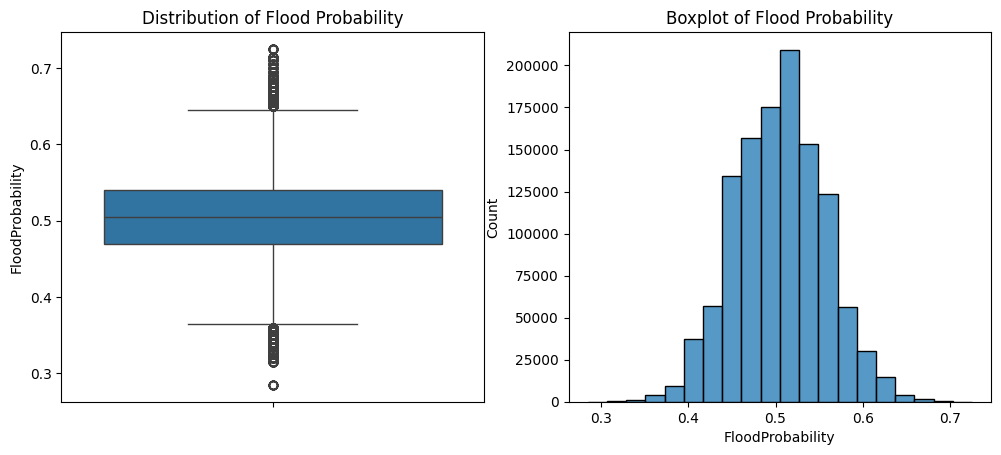

In [371]:
target = 'FloodProbability'
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)

sns.boxplot(data=df, y=target, ax=ax[0])
ax[0].set_title("Distribution of Flood Probability")
sns.histplot(data=df, x=target, ax=ax[1], bins=20)
ax[1].set_title("Boxplot of Flood Probability")

plt.show()

### 🪪 ID

There is exactly a **one-to-one** relationship for the **id** and the **row index** in the dataframe, so we can say with fair confidence this will not be useful for machine learning models, and can be fairly certain that the **id** simply is the row index from just looking at the head and noting this relationship.

In [372]:
len(df['id'].value_counts().keys()), len(df)

(1117957, 1167957)

### 📈 Numerical Columns

After looking at the statistical data from ```describe()```, we know that all of the columns are numeric (either ```int64``` or ```float``` datatypes). So to look at the numeric columns we can just drop the target and the id to get everything of interest.

In [373]:
eda_features = df.drop(['id', target], axis=1).columns
len(eda_features), len(df.columns)

(20, 22)

Certainly since all of the features are integers between 1 and 17 (or even tighter ranges), they can alternatively be seen as categorical variables of up to 17 categories as well. This may not be desirable given that it would greatly increase dimensionality and likely lead to some significantly underrepresented classes when encoded, but it could still be something of note.
* The distribution of the numeric features is extremely similar. Most are between 0 and 10 for their 25-75% quartile whiskers, and about 4 and 6 for their interquartiles. There are always a few outliers, but certainly not many.
* Looking at scatterplots, every single feature tends to follow similar patterns: outliers $>10$ lead to notable increases in **Flood Probability** (usually of $~20$%).
* Looking at the histograms in relation to the target variable, 

In [374]:
# Plotting can take some time and the figure is saved locally, so only do this if you want to.
plot_continuous_variables = False

if plot_continuous_variables == True:
    # We want to plot each feature on its own row with a histogram, boxplot, and regression line
    fig, axes = plt.subplots(len(eda_features), 3)
    fig.set_figwidth(16)
    fig.set_figheight(len(eda_features) * 5)

    for i in range(len(eda_features)):
        ax = axes[i]
        sns.boxplot(data=df, y=eda_features[i], ax=ax[0])
        ax[0].set_title("Distribution of " + eda_features[i])

        sns.histplot(data=df, x=eda_features[i], ax=ax[1], bins=20)
        ax[1].set_title("Histogram of " + eda_features[i])

        sns.boxplot(data=df, x=eda_features[i], y=target, ax=ax[2])
        # sns.regplot(data=df, x=eda_features[i], y=target, ax=ax[2])
        ax[2].set_title("Relationship between " + eda_features[i] + " and target")

    plt.show()

The below snippet looks at values in features that have extremely poor distributions. Looking at the histograms between features and the **Flood Probability** above, there are a few towards the high-end that behave erratically, going against trends, showing wider ranges, and generally being a bit less-valuable.
* In general, most features with values $>15$ tend to have very small support.

In [375]:
# for i in eda_features:
#     vc = df[i].value_counts()
#     for j in vc.keys():
#         if vc[j] < 50:
#             print(i, j, vc[j])

## Feature Engineering

### Sum

Since most of the numerical features are fairly similar, it might be worth taking some aggregate of all features to see if that has any value.

From the scatterplot, we can see ar eally clear regression line . The distance from these outliers from the line appears worst at towards the **min** and **max** values of **flood probability**, as well as at **sums** of ```75``` and ```105```, wherein perhaps key features may be overrepresenting flood probability to what the sum can show.

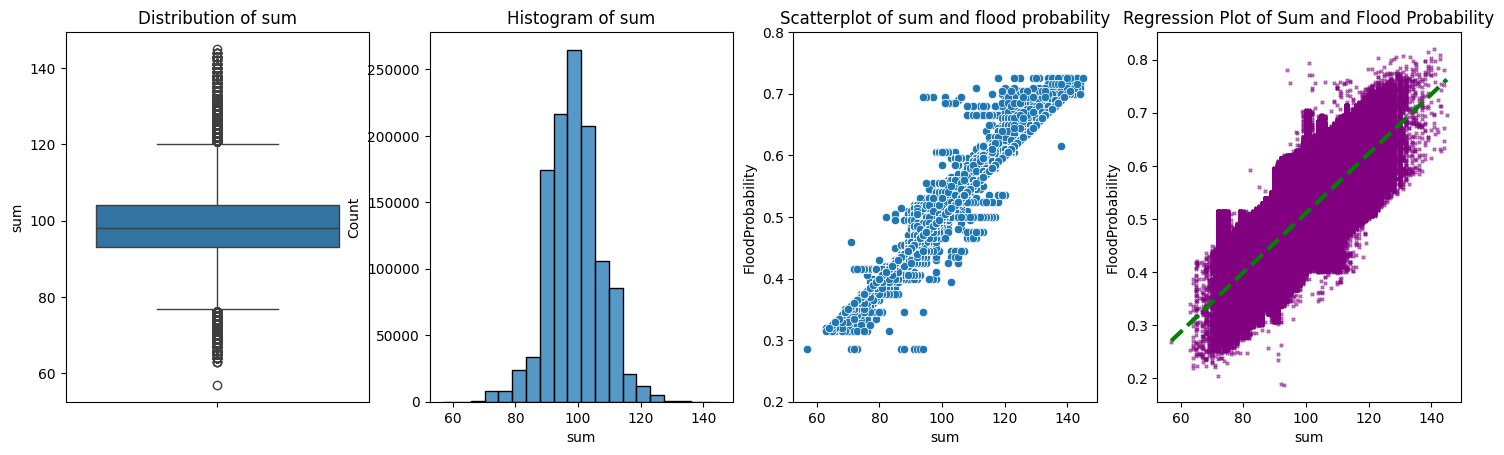

In [376]:
df['sum'] = df['MonsoonIntensity'] + df['TopographyDrainage'] + df['RiverManagement'] + df['Deforestation'] +  df['Urbanization'] +  df['ClimateChange'] + df['DamsQuality'] + df['Siltation'] + df['AgriculturalPractices'] + df['Encroachments'] + df['IneffectiveDisasterPreparedness'] + df['DrainageSystems'] + df['CoastalVulnerability'] + df['Landslides'] + df['Watersheds'] + df['DeterioratingInfrastructure'] + df['PopulationScore'] + df['WetlandLoss'] + df['InadequatePlanning'] + df['PoliticalFactors']

fig, axes = plt.subplots(1, 4)
fig.set_figwidth(18)
sns.boxplot(data=df, y='sum', ax=axes[0])
axes[0].set_title("Distribution of sum")
sns.histplot(data=df, x='sum', ax=axes[1], bins = 20)
axes[1].set_title("Histogram of sum")
sns.scatterplot(data=df, x='sum', y=target, ax=axes[2])
axes[2].set_ylim((0.2, 0.8))
axes[2].set_title("Scatterplot of sum and flood probability")
sns.regplot(data = df, x='sum', y=target,
            line_kws={'color': 'green', 'linewidth': 3, 'linestyle': '--'},
            scatter_kws={'color': 'purple', 's': 5, 'alpha': 0.6},
            # ci=None,  # Remove the confidence interval
            ci=0.95,
            marker='x',  # Change marker style
            x_jitter=0.1,
            y_jitter=0.1,
            ax=axes[3])
axes[3].set_title("Regression Plot of Sum and Flood Probability")
plt.show()

#### Regression with Sum Feature

The below cell creates a Linear Regression model fit on the **flood probability** as a function of the **sum** values.
The equation of the linear regression we get is:

$y=0.0056x - 0.0491$

In [377]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(df[['sum']], df[target])
lr.coef_
print("y =", lr.coef_[0], "x +", lr.intercept_)

y = 0.005599208227274932 x + -0.04913604735655086


Now that the linear regression model is fit, we can make predictions.

In [378]:
df['sum_preds'] = lr.predict(df[['sum']])
df[['sum_preds', target]].head()

,sum_preds,FloodProbability
0,0.477190,0.445
1,0.477190,0.450
2,0.505186,0.530
3,0.533182,0.535
4,0.354007,0.415


Here we make a new dataframe that contains the **error** of the LinearRegression model, sorted in descending order.
We can see that the worst values are up to $20%$ off of the mark for **flood probability**.

In [379]:
df_new = pd.DataFrame()
# Same thing as absolute value but shows euclidean distance being used.
# df_new['distances'] = np.sqrt((df['sum_preds'] - df[target])**2)
df_new['distances'] = df['sum_preds'] - df[target]
df_new = df_new.sort_values(by='distances', ascending=False)
df_new.head()

,distances
1067117,0.192190
514690,0.186590
887899,0.186590
331323,0.180991
59103,0.180991


In [380]:
df['sum'].mean()

98.83719434876456

Examining some of the outliers:
* Top 6 biggest distances in regression predictions are very close to $\mu$ of sum. Top $30$ largest distances from regression predictions are still quite close to $\mu$ of sum.
* Generally, outliers seem to be playing a greater role. A few high or low feature values tend to notably alter the probability of a flood
* Certain groups and combinations of features seem to play a part e.g. drainage features, planning features, environmental instability features.
* The linear model tends to **underestimate** (rather than overestimate) the **flood probability**

Individual Data Points (first 35)
* Higher **deforestation** and **inadequate planning**
* Very high **monsoon intensity** and **enroachments**, higher **population score** and **topography drainage** while other variables remain low.
* Higher **wetland loss** and **deforestation**
* Very high **climate change**, **population score**, notably high **innefective disaster preparedness**
* Very high **deteriorating infrastructure**, **wetland loss**, and **inadequate planning**
* Overestimated with only high **inadequate planning**, **wetland loss** and **watersheds**
* Overestimated high outlier **river management**, outlier **drainage systems**. Had several low values in the second quartile as well
* Overestimated, had perfect **disaster preparedness**, good **planning**, **politics**, and **monsoon intensity**. Had outlier **dams quality** and high **topography drainage**.
* Overestimated with no outliers. Had lots of high values, but **perfect planning**.
* There are many $~20%$ estimations where all the values are within the whiskers
* Underestimated with no outliers. Highest values were **watersheds** and **urbanization** respectively.
* Overestimated, no outliers but good **infrastructure**, **disaster preparedness**, and **agricultural practices**
* Overestimated, no outliers. Good **agricultural practices** and decent **drainage**, **deforestation**, and **disaster preparedness**.
* Overestimated. High **dams quality** outlier, but good **enroachments**, **wetlands**, decent **climate change**, **drainage**.
* Overestimated. No outliers, high **urbanization**, and **infrastructure** with bad **topography drainage**. Really good **drainage systems**, good **river management** and **population score**. Decent **dams**.
* Underestimated. No outliers, high **climate change**, **vulnerability** and **wetland loss**. **Drainage**, **dam quality**, **disaster preparedness** and **adequate planning** were decent but none were far out of the inner quartiles amazing. **population score** was in the lower quartile.
* Overestimated. Really good **agricultural practices**, and **encroachments**. Low **coastal vulnerability**, **watersheds**, and **enroachments**. High **inadequate planning** and **dams quality**, medium high **disaster preparedness**.
* Overestimated with perfect **planning**, nothing terrible just high **deforestation** and **urbanization**.
* Underestimated with high **climate change**, **deteriorating infrastructure**, and **drainage**. Good**coastal vulnerability**, **political factors**, **river management**, **siltation**, **agricultural practices**, **landslides**, and **watersheds**.
* Underestimated with bad **disaster preparedness** and **planning**. Many decent values but only **wetlands** were in the bottom whisker.
* Underestimated with bad **watersheds**, **agricultural practices** and **dams quality**. Nothign was below $3$.
* Overestimated. Only **river management** was bad, whereas **planning** was good, **disaster preparedness** was decent along with a few other variables.
* Underestimated. Outlier in **topography drainage** and high **monsoon**, **drainage systems**, and **landslide**. Had good **infrastructure** and **disaster preparedness**
* Underestimated. High **urbanization** and relatively-high **climate change** with no values $<= 2$
* Underestimated. Really good **river management**, but heavy **monsoon intensity**, **deforestation**, and **encroachments**
* Overestimated. Terrible **drainage systems** but good **monsoon intensity**, **urbanization**, and **enroachments**. Several decent scores for **topography drainage**, **agricultural practices**, **coastal vulnerability**, **population score**, and **adequate planning**.
* Underestimated. High outlier **agricultural practices**, and fairly high **encroachments** and **deforestation**. Only values $<3$ are **political factors**, **dam quality** and **topography drainage**. **Drainage systems** weren't great.
* Underestimated. High **river management**, **monsoon intensity**, **siltation** and **innefective disaster preparedness**. Only good **urbanization** and **deforestation**.
* Underestimated. High **deteriorating infrastructure**, **inadequate planning**, **river management**, and **wetland loss**. Only good **agricultural practices**. and **dam quality**.
* Underestimated (with very high actual probability of flood). Outliers in **politics** and **river management**. **monsoon intensity**, **population score**, **wetland loss**, were all good at $3$.
* Overestimated. Outlier in **agricultural practices**, with high **enroachments** and **river management**. Really good **landslides** score.

In [381]:
distances = 0
for i in range(1000):
    curr_row = df.iloc[df_new.iloc[i].name]
    distances = distances + (curr_row[target] - curr_row['sum_preds'])
distances

-79.24279572169387

In [386]:
# Calculate z-scores for each column
z_scores = df.apply(zscore)

# Sum the z-scores across the columns for each row
df['z_score_agg'] = z_scores.sum(axis=1)
df.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability,sum,sum_preds,z_score_agg
0,0.0,5,8,5,8,6,4,4,3,3,...,5,4,7,5,7,3,0.445,94,0.477190,-5.297748
1,1.0,6,7,4,4,8,8,3,5,4,...,3,5,3,3,4,3,0.450,94,0.477190,-5.174491
2,2.0,6,5,6,7,3,7,1,5,4,...,5,6,8,2,3,3,0.530,99,0.505186,0.764335
3,3.0,3,4,6,5,4,8,4,7,6,...,4,4,6,5,7,5,0.535,104,0.533182,4.942830
4,4.0,5,3,2,6,4,4,3,3,3,...,6,4,1,2,3,5,0.415,72,0.354007,-24.045381


In [387]:
df.iloc[df_new.iloc[5].name]['MonsoonIntensity']

4.0

In [ ]:
# for i in range(20):
df.iloc[df_new.iloc[5].name]

id                                 242964.000000
MonsoonIntensity                        4.000000
TopographyDrainage                      7.000000
RiverManagement                         5.000000
Deforestation                           7.000000
Urbanization                            4.000000
ClimateChange                           5.000000
DamsQuality                             8.000000
Siltation                               2.000000
AgriculturalPractices                   6.000000
Encroachments                           4.000000
IneffectiveDisasterPreparedness         4.000000
DrainageSystems                         3.000000
CoastalVulnerability                    6.000000
Landslides                              4.000000
Watersheds                              1.000000
DeterioratingInfrastructure             4.000000
PopulationScore                         3.000000
WetlandLoss                             3.000000
InadequatePlanning                      3.000000
PoliticalFactors    

<Axes: xlabel='z_score_agg', ylabel='FloodProbability'>

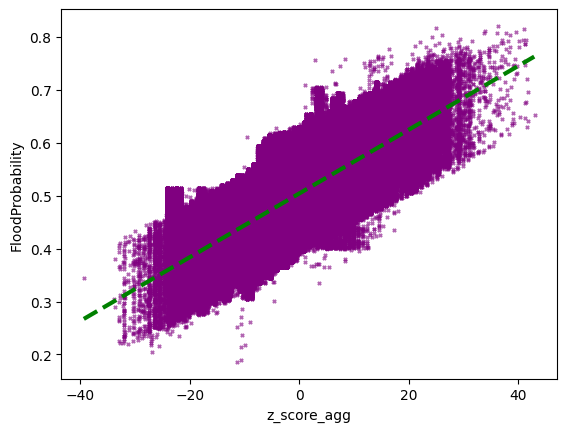

In [ ]:
sns.regplot(data=df, x='z_score_agg', y=target, 
    line_kws={'color': 'green', 'linewidth': 3, 'linestyle': '--'},  
     scatter_kws={'color': 'purple', 's': 5, 'alpha': 0.6},
    # ci=None,  # Remove the confidence interval
    ci=0.95,
    marker='x',  # Change marker style
    x_jitter=0.1,
    y_jitter=0.1,
    )
plt.title("Regression Plot of Aggregate Z Score and Flood Probability")
plt.show()

In [ ]:
lr_mult = LinearRegression()
lr_mult.fit(df[['sum', 'z_score_agg']], df[target])
lr_mult.intercept_, lr_mult.coef_

(4.126574843680565,
 array([-2.39679027e-04,  1.85833079e-04, -6.38558268e-05, -3.01284707e-04,
         6.77443696e-05, -2.30029434e-04,  6.52386749e-05, -1.33016933e-04,
        -1.03064443e-04,  6.63106235e-05,  1.39521498e-07, -5.85391093e-05,
         1.30995098e-04,  2.57552028e-06,  5.08234770e-05, -1.47164240e-04,
        -3.77583335e-05, -1.03030874e-04,  3.55059317e-05,  1.46571290e-04,
        -3.66159453e-02,  4.45890469e-02]))

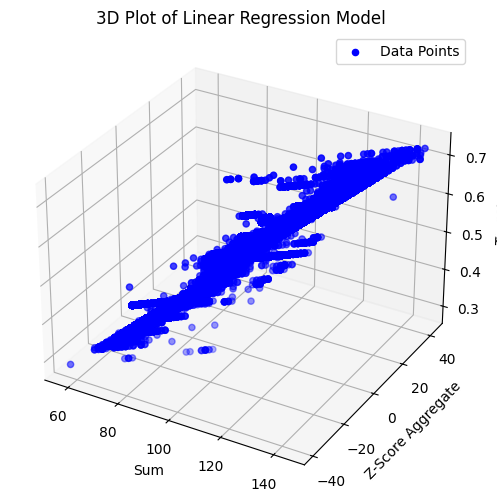

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

intercept = lr_mult.intercept_
coef = lr_mult.coef_

# Create a meshgrid for the regression plane
x_surf, y_surf = np.meshgrid(np.linspace(df['sum'].min(), df['sum'].max(), 100), 
                             np.linspace(df['z_score_agg'].min(), df['z_score_agg'].max(), 100))
z_surf = intercept + coef[0] * x_surf + coef[1] * y_surf

# Create the 3D plot
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111, projection='3d')

# Plot the regression plane
# ax.plot_surface(x_surf, y_surf, z_surf, color='red', alpha=0.5, rstride=100, cstride=100)

# Plot the data points
ax.scatter(df['sum'], df['z_score_agg'], df[target], color='blue', label='Data Points')

ax.set_xlabel('Sum')
ax.set_ylabel('Z-Score Aggregate')
ax.set_zlabel('Target')
ax.set_title('3D Plot of Linear Regression Model')

plt.legend()
plt.show()

In [ ]:
preds_mult = lr_mult.predict(df[['sum', 'z_score_agg']])
preds_mult

array([0.445, 0.45 , 0.53 , ..., 0.43 , 0.515, 0.58 ])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate accuracy metrics
r2 = r2_score(df[target], preds_mult)
mae = mean_absolute_error(df[target], preds_mult)
mse = mean_squared_error(df[target], preds_mult)
rmse = np.sqrt(mse)

print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

R^2 Score: 1.0
Mean Absolute Error (MAE): 1.4310525995149174e-15
Mean Squared Error (MSE): 3.246180460068939e-30
Root Mean Squared Error (RMSE): 1.8017159765259725e-15


## 🤸 Splitting Data

In [391]:
from sklearn.model_selection import train_test_split

features = list(eda_features)
features.append('sum')
features.append('z_score_agg')

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,
    y,
    test_size=0.2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((934365, 22), (934365,), (233592, 22), (233592,))

## 🤖 Machine Learning

### Gradient Boosting Regressor

In [394]:
gbr = GradientBoostingRegressor(n_estimators = 550, learning_rate = 0.1, max_depth=5, random_state=5)
gbr.fit(X, y)

GradientBoostingRegressor(max_depth=5, n_estimators=550, random_state=5)

In [ ]:
df_submit = pd.read_csv('./sample_submission.csv')
df_submit.head()

,id,FloodProbability
0,1117957,0.5
1,1117958,0.5
2,1117959,0.5
3,1117960,0.5
4,1117961,0.5


In [ ]:
df_test = pd.read_csv('./test.csv')
df_test.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,...,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,...,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,...,7,9,2,5,5,2,3,6,8,3
3,1117960,2,4,4,6,4,5,4,3,4,...,7,8,4,6,7,6,4,2,4,4
4,1117961,6,3,2,4,6,4,5,5,3,...,4,3,2,6,4,6,8,4,5,5


In [ ]:
df_test['sum'] = df_test['MonsoonIntensity'] + df_test['TopographyDrainage'] + df_test['RiverManagement'] + df_test['Deforestation'] +  df_test['Urbanization'] +  df_test['ClimateChange'] + df_test['DamsQuality'] + df_test['Siltation'] + df_test['AgriculturalPractices'] + df_test['Encroachments'] + df_test['IneffectiveDisasterPreparedness'] + df_test['DrainageSystems'] + df_test['CoastalVulnerability'] + df_test['Landslides'] + df_test['Watersheds'] + df_test['DeterioratingInfrastructure'] + df_test['PopulationScore'] + df_test['WetlandLoss'] + df_test['InadequatePlanning'] + df_test['PoliticalFactors']

z_scores = df_test.apply(zscore)

# Sum the z-scores across the columns for each row
df_test['z_score_agg'] = z_scores.sum(axis=1)

df_test.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,sum,z_score_agg
0,1117957,4,6,3,5,6,7,8,7,8,...,7,5,6,3,6,4,4,5,111,5.591020
1,1117958,4,4,2,9,5,5,4,7,5,...,7,4,5,1,7,4,4,3,90,-7.009991
2,1117959,1,3,6,5,7,2,4,6,4,...,2,5,5,2,3,6,8,3,90,-7.037646
3,1117960,2,4,4,6,4,5,4,3,4,...,4,6,7,6,4,2,4,4,92,-5.831661
4,1117961,6,3,2,4,6,4,5,5,3,...,2,6,4,6,8,4,5,5,92,-5.818660


In [ ]:
# test_preds = lr_mult.predict(df_test[['sum', 'z_score_agg']])
test_preds = lr_mult.predict(df_test[features])
test_preds

array([0.30852716, 0.51449028, 0.51466454, ..., 0.37508384, 0.50300717,
       0.57146334])

In [ ]:
df_submit = pd.DataFrame()
df_submit['id'] = df_test['id']
df_submit['FloodProbability'] = test_preds
df_submit.head()

,id,FloodProbability
0,1117957,0.308527
1,1117958,0.514490
2,1117959,0.514665
3,1117960,0.494832
4,1117961,0.495167


In [ ]:
df_submit.to_csv('./submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "Attempting submission with linear regression not trained on anything useful"

100%|██████████████████████████████████████| 19.3M/19.3M [00:01<00:00, 12.3MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

## Data Cleaning

### Drop ID

In [ ]:
'''
Drops the name column in the df dataframe if it is present
   Allows the data cleaning pipeline to be called multiple times if necessary
'''
def drop_column(name, df):
    if name in df_ret.columns:
        df_ret = df.copy()
        df_ret = df_ret.drop(name, axis=1)
        return df_ret
    else:
        return df

# Make sure that ID is added to this list for the cleaning pipeline 
columns_to_drop = ['id']